# Trajectory analysis using Lagranto


**References:**  
Sprenger, M. and Wernli, H.: The LAGRANTO Lagrangian analysis tool – version 2.0, Geosci. Model Dev., 8, 2569–2586, https://doi.org/10.5194/gmd-8-2569-2015, 2015.

<span style="color: mediumblue;">Load python packages</span>

In [1]:
from IPython.display import HTML
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import numpy as np
import sys
import os

<span style="color: mediumblue;">Set and load the paths for WxSysLib installed on your local directory (⚠️you will need to `git clone` the entire WxSysLib to your own directory first)</span>

In [2]:
os.environ['WXSYSLIBDIR']='/g/data/if69/cj0591/WxSysLib'
sys.path.append(os.environ['WXSYSLIBDIR'])

<span style="color: mediumblue;">Set and load the path for Lagranto on `gb02/public/tools/Wx`</span>

In [3]:
os.environ['LAGRANTODIR']='/g/data/gb02/public/tools/Wx/lagranto.fortran' # ⚠️ don't change directory here

<span style="color: mediumblue;">Set up dask</span>

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=7)

<span style="color: mediumblue;">Load lagranto utils</span>

In [5]:
from utils.diagnostics.Lagranto.lagranto_utils import (
run_Lagranto,
modify_traj,
get_Pfiles,
create_lagranto_dirstruct
)

from utils.diagnostics.Lagranto.startf import (
create_starf_point,
create_starf_line,
create_starf_box
)

from utils.plotting.lagranto_plotting import (
plot_traj,
animate_traj
)

<span style="color: mediumblue;">Create required directories using `create_lagranto_dirstruct`</span> 

In [6]:
work_dir = '/scratch/if69/cj0591'  # ⚠️ change to your own directory
casename = 'lagranto_example'
dirs = create_lagranto_dirstruct(work_dir, casename)
casepath = dirs[0]

Directory '/scratch/if69/cj0591/lagranto_example' already exists.
Directory '/scratch/if69/cj0591/lagranto_example/starf' already exists.
Directory '/scratch/if69/cj0591/lagranto_example/pfile' already exists.
Directory '/scratch/if69/cj0591/lagranto_example/traj' already exists.


<span style="color: mediumblue;">Get P files from ERA5</span>

**P files** should be ready before running Lagranto  

A P file is netcdf file, named as PYYYYMMdd_HH

At an instanously time, a P file contains:


| Variable Name                 | Level                             |Unit                              |
|-------------------------------|-----------------------------------|----------------------------------|
| U-component Wind (U)          | 37 pressure levels                |m/s                               |
| V-component Wind (V)          | 37 pressure levels                |m/s                               |
| Vertical velocity (OMEGA)     | 37 pressure levels                |Pa/s                              |
| Surface pressure (PS)         | surface                           |Pa                                |

⚠️ These four variables are compulsory for running trajectories!


`get_Pfiles` is used to create Pfiles

In [13]:
lon_range  = (-180,    180,    0.5)           # longitude range
lat_range  = (   0,  -90.5,   -0.5)           # latitude range
hour_range = (0, 24, 3)                       # 3-hourly, 6-hourly
reference_datetime = datetime(2009, 2, 7, 00)
period = -120

pfiledir = f'{casepath}/pfile'
get_Pfiles(reference_datetime, period, lon_range, lat_range, hour_range, pfiledir)

Creating P20090202_00...
     0:00:11.970675
Creating P20090202_03...
     0:00:11.133256
Creating P20090202_06...
     0:00:11.305684
Creating P20090202_09...
     0:00:12.566036
Creating P20090202_12...
     0:00:12.122754
Creating P20090202_15...
     0:00:12.283626
Creating P20090202_18...
     0:00:12.646918
Creating P20090202_21...
     0:00:11.107822
Creating P20090203_00...
     0:00:12.757433
Creating P20090203_03...
     0:00:11.218542
Creating P20090203_06...
     0:00:10.925868
Creating P20090203_09...
     0:00:10.877063
Creating P20090203_12...
     0:00:12.246557
Creating P20090203_15...
     0:00:10.419642
Creating P20090203_18...
     0:00:12.061458
Creating P20090203_21...
     0:00:11.560188
Creating P20090204_00...
     0:00:13.023174
Creating P20090204_03...
     0:00:12.961614
Creating P20090204_06...
     0:00:13.829833
Creating P20090204_09...
     0:00:12.461174
Creating P20090204_12...
     0:00:12.646525
Creating P20090204_15...
     0:00:10.401825
Creating P

An exmaple P file is shown below:

In [8]:
ds = xr.open_dataset(f'{casepath}/pfile/P20090202_00')
ds

<xarray.Dataset> Size: 117MB
Dimensions:  (lev: 37, lat: 181, lon: 720, time: 1)
Coordinates:
  * lev      (lev) int32 148B 100 200 300 500 700 ... 92500 95000 97500 100000
  * lat      (lat) float32 724B -90.0 -89.5 -89.0 -88.5 ... -1.5 -1.0 -0.5 0.0
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * time     (time) datetime64[ns] 8B 2009-02-02
Data variables:
    U        (time, lev, lat, lon) float64 39MB ...
    V        (time, lev, lat, lon) float64 39MB ...
    OMEGA    (time, lev, lat, lon) float64 39MB ...
    PS       (time, lat, lon) float64 1MB ...

Feel free to delete Pfiles after trajectories are calcualted

<span style="color: mediumblue;">Create starting points</span>  
* create single point using `create_starf_point`
* create a region of points `create_starf_box`  

In [18]:
create_starf_box(
    f'{casepath}/starf/box.fortranonly', 144, 145, -38, -36, 0.5, [925, 850, 700, 500] 
    # a box bounded [lon_min, lon_max, lat_min, lat_max, grid_spacing] on 925 hPa
)

In [19]:
!cat {casepath}/starf/box.fortranonly

0.00 144.0 -38.0 925
0.00 144.0 -37.5 925
0.00 144.0 -37.0 925
0.00 144.0 -36.5 925
0.00 144.0 -36.0 925
0.00 144.5 -38.0 925
0.00 144.5 -37.5 925
0.00 144.5 -37.0 925
0.00 144.5 -36.5 925
0.00 144.5 -36.0 925
0.00 145.0 -38.0 925
0.00 145.0 -37.5 925
0.00 145.0 -37.0 925
0.00 145.0 -36.5 925
0.00 145.0 -36.0 925
0.00 144.0 -38.0 850
0.00 144.0 -37.5 850
0.00 144.0 -37.0 850
0.00 144.0 -36.5 850
0.00 144.0 -36.0 850
0.00 144.5 -38.0 850
0.00 144.5 -37.5 850
0.00 144.5 -37.0 850
0.00 144.5 -36.5 850
0.00 144.5 -36.0 850
0.00 145.0 -38.0 850
0.00 145.0 -37.5 850
0.00 145.0 -37.0 850
0.00 145.0 -36.5 850
0.00 145.0 -36.0 850
0.00 144.0 -38.0 700
0.00 144.0 -37.5 700
0.00 144.0 -37.0 700
0.00 144.0 -36.5 700
0.00 144.0 -36.0 700
0.00 144.5 -38.0 700
0.00 144.5 -37.5 700
0.00 144.5 -37.0 700
0.00 144.5 -36.5 700
0.00 144.5 -36.0 700
0.00 145.0 -38.0 700
0.00 145.0 -37.5 700
0.00 145.0 -37.0 700
0.00 145.0 -36.5 700
0.00 145.0 -36.0 700
0.00 144.0 -38.0 500
0.00 144.0 -37.5 500
0.00 144.0 -3

<span style="color: mediumblue;">Run trajectory</span>

In [29]:
reference_datetime_str = reference_datetime.strftime("%Y%m%d_%H")

run_Lagranto(f'{casepath}/starf/box.fortranonly',
             period,
             f'{casepath}/traj/traj.fortran',
             180, 180,
             reference_datetime_str,
             f'{casepath}/pfile/',
             quiet=True)

<span style="color: mediumblue;">The original Lagranto trajectory file looks like:</span>

In [30]:
!cat {casepath}/traj/traj.fortran

Reference date 20090207_0000 / Time range   -7200 min

  time      lon     lat     p
-----------------------------

   0.00   144.00  -38.00   925
  -3.00   143.69  -36.09   934
  -6.00   144.19  -34.77   933
  -9.00   144.88  -34.28   910
 -12.00   145.37  -34.28   871
 -15.00   145.59  -34.44   838
 -18.00   145.58  -34.53   818
 -21.00   145.50  -34.59   787
 -24.00   145.18  -34.73   754
 -27.00   144.60  -34.89   735
 -30.00   143.99  -34.91   715
 -33.00   143.46  -34.90   701
 -36.00   143.04  -34.99   685
 -39.00   142.50  -35.35   675
 -42.00   141.50  -35.92   663
 -45.00   139.67  -36.54   639
 -48.00   136.89  -36.89   608
 -51.00   133.56  -36.77   598
 -54.00   130.28  -36.29   600
 -57.00   127.24  -35.69   606
 -60.00   124.39  -35.14   604
 -63.00   121.56  -34.69   608
 -66.00   118.87  -34.17   606
 -69.00   116.50  -33.60   610
 -72.00   114.44  -33.19   612
 -75.00   112.39  -33.02   604
 -78.00   110.29  -32.96   593
 -81.00   108.04  -32.94   581
 -84.00   105.65

<span style="color: mediumblue;">Read trajectory as pandas dataframe using `modify_traj`</span>

In [31]:
df_traj = modify_traj(f'{casepath}/traj/traj.fortran')

In [32]:
df_traj

,time,lon,lat,p,track_id
0,0.0,144.00,-38.00,925,1
1,-3.0,143.69,-36.09,934,1
2,-6.0,144.19,-34.77,933,1
3,-9.0,144.88,-34.28,910,1
4,-12.0,145.37,-34.28,871,1
...,...,...,...,...,...
2455,-108.0,124.52,-35.72,415,60
2456,-111.0,122.94,-35.31,403,60
2457,-114.0,121.44,-35.05,391,60
2458,-117.0,119.91,-34.91,382,60


<span style="color: mediumblue;">Visualise trajectories using `plot_traj` or `animate_traj`</span>

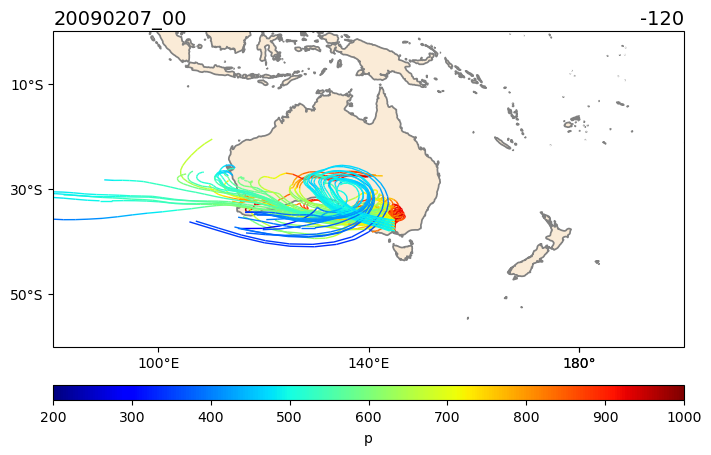

In [33]:
fig = plot_traj(df_traj, 'p', 200, 1000, 80, 200, -60, 0, 'jet', reference_datetime_str, period)

In [ ]:
anim_track = animate_traj(df_traj, 'p', 200, 1000, 80, 200, -60, 0, 125, 'jet',
                          reference_datetime_str)
HTML(anim_track.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
